# Зависимости

In [1]:
!pip -q install torch torchvision torchaudio transformers sentence-transformers scikit-learn datasets accelerate


In [2]:
!pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.6/23.6 MB 64.1 MB/s eta 0:00:00


# Импорт, чтение и сплит

In [3]:
import json, os, random, math
from pathlib import Path
from collections import Counter
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import requests  # добавили

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

# подгружаем датасеты через GitHub
BASE_URL = "https://raw.githubusercontent.com/Fla1lx/neural-network-module-for-determining-user-intent/main"

TRAIN_URL = f"{BASE_URL}/lbd_train.jsonl"
DEV_URL   = f"{BASE_URL}/lbd_dev.jsonl"   # поправь путь, если файлы лежат в подпапке, например data/nlu/...

def load_jsonl_from_url(url: str):
    resp = requests.get(url)
    resp.raise_for_status()
    lines = resp.text.splitlines()
    return [json.loads(line) for line in lines if line.strip()]

rows     = load_jsonl_from_url(TRAIN_URL)
dev_rows = load_jsonl_from_url(DEV_URL)

print("train samples:", len(rows))
print("train by skill:", Counter(r["skill"] for r in rows))
print("dev samples:", len(dev_rows))
print("dev by skill:", Counter(r["skill"] for r in dev_rows))


train samples: 1414
train by skill: Counter({'music.play': 194, 'weather.get': 189, 'reminder.add': 149, 'timer.start': 148, 'alarm.set': 146, 'time.now': 108, 'news.get': 107, 'math.calculate': 102, 'music.stop': 101, 'jokes.tell': 92, 'system.help': 78})
dev samples: 255
dev by skill: Counter({'weather.get': 43, 'music.play': 32, 'math.calculate': 26, 'alarm.set': 24, 'music.stop': 24, 'timer.start': 21, 'reminder.add': 20, 'system.help': 19, 'news.get': 18, 'time.now': 17, 'jokes.tell': 11})


# Маскирование
Находим в тексте ключевые слова и заменяем на плейсхолдевы (masked , slots)

In [4]:
import re
from typing import Dict, Any, Tuple, List

# утилиты
def _store(slots: Dict[str, Any], key: str, value: str, placeholder: str, canon_key=None, canon_val=None):
    slots.setdefault(key, []).append(value.strip())
    if canon_key:
        slots.setdefault(canon_key, []).append(canon_val)
    return placeholder

def _canon(text: str) -> str:
    # мягкая канонизация для сравнения/логов
    t = text.strip()
    t = re.sub(r"\s+", " ", t)
    return t

def _merge_spans(spans: List[Tuple[int,int,str,str]]):
    spans = sorted(spans, key=lambda x:(x[0], x[1]))
    merged = []
    for s in spans:
        if not merged or s[0] >= merged[-1][1]:
            merged.append(s)
        else:
            # оставляем более длинный
            prev = merged[-1]
            if (s[1]-s[0]) > (prev[1]-prev[0]):
                merged[-1] = s
    return merged

#словари/регулы
TIME_WORDS = r"(сегодня|завтра|послезавтра|утром|днём|днем|вечером|ночью)"
MONTHS = r"(январ[ьяе]|феврал[ьяе]|март[ае]?|апрел[ьяе]|ма[ея]|июн[ьяе]|июл[ьяе]|август[ае]?|сентябр[ьяе]|октябр[ьяе]|ноябр[ьяе]|декабр[ьяе])"
UNITS = r"(секунд(?:а|ы)?|минут(?:а|ы)?|час(?:а|ов)?|дн(?:я|ей|ь))"
PREP = r"(?:в|во|на|из|по|к|у|с|со|под|над|около|между)"
CAP_WORD = r"[A-ZА-ЯЁ][\w\-]+"

# мини-база городов
CITY_LIST = ["москва","санкт-петербург","казань","берлин","лондон","париж","екатеринбург","новосибирск"]

SUFFIXES_FEM = ["а","ы","е","у","ой","ою"]
SUFFIXES_MASC_CONS = ["","а","у","ом","е"]
SUFFIXES_MASC_YJ = ["й","я","ю","ем","е"]
SUFFIXES_SOFT = ["ь","я","ю","ем","е"]
SUFFIXES_NEUT = ["о","а","у","ом","е"]

def _suffixes_for_last_token(tok: str):
    t = tok.lower()
    if t.endswith(("а","я")): return SUFFIXES_FEM
    if t.endswith("й"):       return SUFFIXES_MASC_YJ
    if t.endswith("ь"):       return SUFFIXES_SOFT
    if t.endswith(("о","е")): return SUFFIXES_NEUT
    return SUFFIXES_MASC_CONS

def _city_regex(city: str) -> re.Pattern:
    parts = re.split(r"[\s\-]+", city.strip().lower())
    head, last = parts[:-1], parts[-1]
    def stem(token: str): return re.escape(token[:-1]) if token[-1] in "аяоейь" else re.escape(token)
    suf = _suffixes_for_last_token(last)
    if last[-1] in "аяоейь":
        last_pat = stem(last) + "(?:" + "|".join(map(re.escape, suf)) + ")"
    else:
        opts = "|".join("" if s=="" else re.escape(s) for s in suf)
        last_pat = re.escape(last) + "(?:" + opts + ")"
    head_pat = (r"\b" + r"[-\s]".join(map(re.escape, head)) + r"[-\s]") if head else r"\b"
    return re.compile(head_pat + last_pat + r"\b", flags=re.I)

CITY_PATTERNS = [(c, _city_regex(c)) for c in CITY_LIST]

#основной пайплайн
def mask_entities(text: str) -> Tuple[str, Dict[str, Any]]:
    s: Dict[str, Any] = {}
    raw = text
    spans: List[Tuple[int,int,str,str]] = []

    # защищаем уже существующие
    protected = []
    for m in re.finditer(r"\{[a-z_]+\}", raw):
        protected.append((m.start(), m.end()))
    def _is_protected(a,b):
        return any(not (b<=x or a>=y) for x,y in protected)

    # TIME
    for m in re.finditer(r"\b([01]?\d|2[0-3]):[0-5]\d\b", raw):
        if not _is_protected(m.start(), m.end()):
            spans.append((m.start(), m.end(), "{time}", "time"))

    # DATE
    for m in re.finditer(r"\b([0-3]?\d\.[01]?\d\.\d{4}|[0-3]?\d\.[01]?\d\b)", raw):
        if not _is_protected(m.start(), m.end()):
            spans.append((m.start(), m.end(), "{date}", "date"))
    for m in re.finditer(rf"\b([0-3]?\d)\s+{MONTHS}\b", raw, flags=re.I):
        if not _is_protected(m.start(), m.end()):
            spans.append((m.start(), m.end(), "{date}", "date"))
    for m in re.finditer(r"\b(в\s+понедельник|во\s+вторник|в\s+среду|в\s+четверг|в\s+пятницу|в\s+субботу|в\s+воскресенье)\b", raw, flags=re.I):
        if not _is_protected(m.start(), m.end()):
            spans.append((m.start(), m.end(), "{date}", "date"))

    # TIME WORDS
    for m in re.finditer(TIME_WORDS, raw, flags=re.I):
        if not _is_protected(m.start(), m.end()):
            spans.append((m.start(), m.end(), "{time}", "time"))

    # DURATION
    for m in re.finditer(rf"\b(через|на)\s+\d+\s+{UNITS}(?:\s+\d+\s+{UNITS})?\b", raw, flags=re.I):
        if not _is_protected(m.start(), m.end()):
            spans.append((m.start(), m.end(), "{duration}", "duration"))
    for m in re.finditer(rf"\b\d+\s+{UNITS}\b", raw, flags=re.I):
        if not _is_protected(m.start(), m.end()):
            spans.append((m.start(), m.end(), "{duration}", "duration"))

    #ЧИСЛА для math
    for m in re.finditer(r"(?<!\w)\d+(?:[.,]\d+)?(?!\w)", raw):
        a,b = m.start(), m.end()
        if not any(a<y and b>x for x,y,_,_ in spans):  # не пересекаться с duration/date/time
            if not _is_protected(a,b):
                spans.append((a,b,"{number}","number"))

    # MUSIC
    music_m = re.search(r"(включи|воспроизведи|сыграй|запусти|поставь)\s+(.+)", raw, flags=re.I)
    if music_m and not _is_protected(music_m.start(2), music_m.end(2)):
        spans.append((music_m.start(2), music_m.end(2), "{song}", "song"))

    # CITY
    for _, pat in CITY_PATTERNS:
        for m in pat.finditer(raw):
            if not _is_protected(m.start(), m.end()):
                spans.append((m.start(), m.end(), "{city}", "city"))

    # CITY (неизвестные)
    for m in re.finditer(rf"\b{PREP}\s+({CAP_WORD}(?:\s+{CAP_WORD}){{0,2}})\b", raw):
        a,b = m.start(1), m.end(1)
        if not any(a<y and b>x for x,y,_,_ in spans) and not _is_protected(a,b):
            spans.append((a,b,"{city}","city"))

    #Слияние пересечений
    spans = _merge_spans(spans)

    # Применение замен
    out = list(raw)
    extracted: Dict[str, Any] = {}
    for a,b,ph,slot in sorted(spans, key=lambda t:-t[0]):
        val = raw[a:b]
        _store(extracted, slot, val, ph, canon_key=f"{slot}_canon", canon_val=_canon(val))
        out[a:b] = list(ph)
    masked = "".join(out)
    masked = re.sub(r"\s+", " ", masked).strip()

    return masked, extracted


# Символьный токенайзер
Делаем словарь и конвертируем текст в последовательности индексов

In [5]:
from dataclasses import dataclass
from typing import List, Dict, Union
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import os, random

# --- Расширенный конфиг ---
@dataclass
class Config:
    SEED = 42
    MAX_LEN = 128

    # Архитектура модели
    EMB_DIM = 96
    CNN_CHANNELS = 128
    LSTM_HIDDEN = 128
    PROJ_DIM = 128

    # Обучение
    EPOCHS = 15        # Ставим с запасом, Early Stopping остановит раньше
    LR = 3e-4
    LAMBDA = 0.2       # Вес SupCon loss
    PATIENCE = 3       # Сколько эпох ждать улучшения

    # Спец-токены
    SPECIALS = ["<pad>", "<unk>", "<bos>", "<eos>"]
    PAD_IDX = 0
    UNK_IDX = 1
    BOS_IDX = 2
    EOS_IDX = 3

# Детерминизм
def seed_everything(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        # Для полной воспроизводимости (может немного замедлить обучение)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

seed_everything(Config.SEED)

# Построение словарь
charset = set()
for r in rows:
    charset.update(list(r["text"]))

itos: List[str] = Config.SPECIALS + sorted(charset)
stoi: Dict[str, int] = {ch: i for i, ch in enumerate(itos)}

PAD, UNK, BOS, EOS = Config.PAD_IDX, Config.UNK_IDX, Config.BOS_IDX, Config.EOS_IDX

# Функции кодирования с типизацией
def encode_text(text: str, max_len: int = Config.MAX_LEN) -> np.ndarray:
    # Превращает строку в массив индексов с добавлением BOS/EOS и паддингом.

    # [:max_len-2] оставляет место для BOS и EOS
    ids = [BOS] + [stoi.get(ch, UNK) for ch in text][:max_len-2] + [EOS]

    if len(ids) < max_len:
        ids = ids + [PAD] * (max_len - len(ids))

    return np.array(ids, dtype=np.int64)

# Подготовка лейблов
skills = sorted(list({r["skill"] for r in rows}))
label2id = {s: i for i, s in enumerate(skills)}
id2label = {i: s for s, i in label2id.items()}

# Dataset
class IntentDataset(Dataset):
    def __init__(self, samples: List[Dict], max_len: int = Config.MAX_LEN):
        self.samples = samples
        self.max_len = max_len

    def __len__(self) -> int:
        return len(self.samples)

    def __getitem__(self, i: int):
        r = self.samples[i]
        # Кодируем текст
        x = encode_text(r["text"], self.max_len)
        # Кодируем лейбл
        y = label2id[r["skill"]]
        return torch.tensor(x, dtype=torch.long), torch.tensor(y, dtype=torch.long)

# Сплит и DataLoader
ratio = 0.85
n = len(rows)
n_train = int(n * ratio)
perm = list(range(n))
random.shuffle(perm)

train_rows = [rows[i] for i in perm[:n_train]]
val_rows   = [rows[i] for i in perm[n_train:]]

train_ds = IntentDataset(train_rows, max_len=Config.MAX_LEN)
val_ds   = IntentDataset(val_rows,   max_len=Config.MAX_LEN)

train_dl = DataLoader(train_ds, batch_size=64, shuffle=True, drop_last=True)
val_dl   = DataLoader(val_ds, batch_size=128, shuffle=False)

len_vocab = len(itos)
num_labels = len(skills)

print(f"Vocab size: {len_vocab}, Labels: {num_labels}")
print("Classes:", skills[:5], "...")

Vocab size: 82, Labels: 11
Classes: ['alarm.set', 'jokes.tell', 'math.calculate', 'music.play', 'music.stop'] ...


# Модель
Архитектура : Char-CNN + BiLSTM

CharCNN - ищет локальные паттерны

AdaptiveMaxPool - выравниваем длину признаков

BiLSTM - обрабатываем данные последовательности в двух направлениях: вперед и назад, чтобы захватить контекст из прошлого и будущего

In [6]:
class NLUEncoder(nn.Module):
    def __init__(self, vocab_size, num_labels,
                 emb_dim=Config.EMB_DIM,
                 cnn_channels=Config.CNN_CHANNELS,
                 lstm_hidden=Config.LSTM_HIDDEN,
                 proj_dim=Config.PROJ_DIM):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim, padding_idx=Config.PAD_IDX)
        self.conv = nn.Conv1d(emb_dim, cnn_channels, kernel_size=5, padding=2)
        self.pool = nn.AdaptiveMaxPool1d(64)
        self.bi_lstm = nn.LSTM(input_size=cnn_channels, hidden_size=lstm_hidden,
                               num_layers=1, batch_first=True, bidirectional=True)

        # Голова для Contrastive Loss
        self.proj = nn.Linear(2*lstm_hidden, proj_dim)
        # Голова для классификации
        self.cls  = nn.Linear(2*lstm_hidden, num_labels)

    def forward(self, x):
        # x: [B, T]
        e = self.emb(x)                 # [B, T, E]
        e = e.transpose(1,2)            # [B, E, T] -> для Conv1d
        c = F.relu(self.conv(e))
        c = self.pool(c)                # [B, C, P=64]
        c = c.transpose(1,2)            # [B, P, C] -> для LSTM
        out, _ = self.bi_lstm(c)        # [B, P, 2H]
        feat = out.mean(dim=1)          # [B, 2H] (mean pooling)
        logits = self.cls(feat)         # [B, num_labels]
        z = self.proj(feat)             # [B, proj_dim]
        z = F.normalize(z, dim=-1)      # Нормализация для косинусного сходства

        return logits, z


# Supervised Contrastive Loss
Сближаем эмбеддинги одинаковых скиллов и отдаляем разных

In [7]:
def supcon_loss(z: torch.Tensor, y: torch.Tensor, temperature: float = 0.07) -> torch.Tensor:
    """
    Supervised contrastive loss по батчу эмбеддингов.
    z: [B, D] — нормализованные проекции (эмбеддинги)
    y: [B]    — метки классов
    """
    device = z.device
    B = z.size(0)

    # Вычисляем матрицу схожести [B, B]
    sim = torch.matmul(z, z.t()) / temperature

    # Маски
    mask_self = torch.eye(B, dtype=torch.bool, device=device)
    # Позитивные пары: совпадающий класс, но не сам с собой
    mask_pos = (y.unsqueeze(1) == y.unsqueeze(0)) & ~mask_self

    # Проверка: если в батче нет позитивных пар (все классы уникальны), лосс = 0
    has_pos = mask_pos.any(dim=1)
    if not has_pos.any():
        return torch.zeros([], device=device)

    # Знаменатель: сумма экспонент по всем j != i (для этого mask_self заполняем -inf)
    # logsumexp численно стабильнее, чем log(sum(exp))
    logsumexp_all = torch.logsumexp(sim.masked_fill(mask_self, -1e9), dim=1)

    # Числитель: сумма экспонент только по позитивам
    # (где нет позитива, ставим -inf, чтобы не влияло на сумму)
    logsumexp_pos = torch.logsumexp(sim.masked_fill(~mask_pos, -1e9), dim=1)

    # Считаем лосс только для тех элементов, у которых есть пара
    # Loss = - (log_sum_exp_pos - log_sum_exp_all)
    loss = -(logsumexp_pos[has_pos] - logsumexp_all[has_pos]).mean()

    return loss


# Обучение с нуля
Обучаемся и сохраняем лучший чекпоинт

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Training on: {device}")

model = NLUEncoder(vocab_size=len_vocab, num_labels=num_labels).to(device)

optim = torch.optim.AdamW(model.parameters(), lr=Config.LR, weight_decay=1e-4)
ce_loss = nn.CrossEntropyLoss()

def evaluate():
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for xb, yb in val_dl:
            xb, yb = xb.to(device), yb.to(device)
            logits, _ = model(xb)
            pred = logits.argmax(dim=1)
            correct += int((pred == yb).sum().item())
            total += yb.numel()
    return correct / total if total else 0.0

# Early Stopping
best_acc = 0.0
patience_counter = 0
model_save_path = "models/char_cnn_bilstm/model.pt"
os.makedirs(os.path.dirname(model_save_path), exist_ok=True)

print(f"Starting training for {Config.EPOCHS} epochs with patience {Config.PATIENCE}...")

for ep in range(1, Config.EPOCHS + 1):
    model.train()
    total_loss = 0.0

    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device)

        logits, z = model(xb)

        # Комбинированный лосс
        loss = ce_loss(logits, yb) + Config.LAMBDA * supcon_loss(z, yb)

        optim.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optim.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_dl)
    acc = evaluate()

    print(f"Epoch {ep:02d}: loss={avg_loss:.4f}, val_acc={acc:.3f}")

    # Логика Early Stopping
    if acc > best_acc:
        best_acc = acc
        patience_counter = 0
        # Сохраняем всё необходимое для инференса
        torch.save({
            "state_dict": model.state_dict(),
            "itos": itos,
            "stoi": stoi,
            "skills": skills,
            "config": { # Сохраняем конфиг, чтобы знать параметры при загрузке
                "max_len": Config.MAX_LEN,
                "emb_dim": Config.EMB_DIM,
                # и т.д.
            }
        }, model_save_path)
        print(f"  --> New best model saved! (acc: {best_acc:.3f})")
    else:
        patience_counter += 1
        print(f"  --> No improvement. Patience: {patience_counter}/{Config.PATIENCE}")

        if patience_counter >= Config.PATIENCE:
            print("Early stopping triggered.")
            break

print(f"Training finished. Best val_acc: {best_acc:.3f}")


Training on: cpu
Starting training for 15 epochs with patience 3...
Epoch 01: loss=2.7459, val_acc=0.131
  --> New best model saved! (acc: 0.131)
Epoch 02: loss=2.4777, val_acc=0.249
  --> New best model saved! (acc: 0.249)
Epoch 03: loss=2.3454, val_acc=0.451
  --> New best model saved! (acc: 0.451)
Epoch 04: loss=2.1825, val_acc=0.587
  --> New best model saved! (acc: 0.587)
Epoch 05: loss=1.8976, val_acc=0.681
  --> New best model saved! (acc: 0.681)
Epoch 06: loss=1.4875, val_acc=0.704
  --> New best model saved! (acc: 0.704)
Epoch 07: loss=1.0601, val_acc=0.770
  --> New best model saved! (acc: 0.770)
Epoch 08: loss=0.8654, val_acc=0.817
  --> New best model saved! (acc: 0.817)
Epoch 09: loss=0.7218, val_acc=0.901
  --> New best model saved! (acc: 0.901)
Epoch 10: loss=0.5964, val_acc=0.901
  --> No improvement. Patience: 1/3
Epoch 11: loss=0.4825, val_acc=0.925
  --> New best model saved! (acc: 0.925)
Epoch 12: loss=0.3591, val_acc=0.934
  --> New best model saved! (acc: 0.934)
E

# Инференс


In [9]:
# Загрузка чекпоинта
ckpt = torch.load("models/char_cnn_bilstm/model.pt", map_location=device)
model.load_state_dict(ckpt["state_dict"])

# Восстанавливаем словари из чекпоинта, чтобы гарантировать совместимость
itos = ckpt["itos"]
stoi = ckpt["stoi"]
skills = ckpt["skills"]

# Обновляем маппинги
label2id = {s: i for i, s in enumerate(skills)}
id2label = {i: s for s, i in label2id.items()}

model.eval()

def encode_for_model(text: str, max_len: int = Config.MAX_LEN):
    #Кодирует текст для подачи в модель (возвращает тензор на нужном устройстве).
    #Использует глобальный словарь stoi, загруженный из чекпоинта.

    # Используем те же спец-токены из Config (или жестко задаем, если Config недоступен)
    # Но лучше брать индексы из загруженного stoi
    BOS_IDX = stoi.get("<bos>", Config.BOS_IDX)
    EOS_IDX = stoi.get("<eos>", Config.EOS_IDX)
    UNK_IDX = stoi.get("<unk>", Config.UNK_IDX)
    PAD_IDX = stoi.get("<pad>", Config.PAD_IDX)

    # Токенизация
    ids = [BOS_IDX] + [stoi.get(ch, UNK_IDX) for ch in text][:max_len-2] + [EOS_IDX]

    # Паддинг
    if len(ids) < max_len:
        ids = ids + [PAD_IDX] * (max_len - len(ids))

    # Возвращаем тензор с размерностью батча [1, T]
    return torch.tensor([ids], dtype=torch.long, device=device)

@torch.no_grad()
def clf_prob_ours(masked_text: str):
    xb = encode_for_model(masked_text)
    logits, z = model(xb)
    probs = torch.softmax(logits, dim=-1)[0].cpu().numpy()
    k = int(probs.argmax())
    return float(probs[k]), id2label[k], z[0].cpu().numpy()

# FAISS
Посчитаем эмбеддинги всех фраз в нашей LBD

Сделаем быстрый поиск ближайших векторов (FAISS)

Сможем по новым фразам искать ближайщие примеры

In [10]:
import faiss
import numpy as np
import torch

# ---- 1. Приводим rows/dev_rows к формату SPR ----

def to_spr(rows, default_locale: str = "ru"):
    """
    Преобразуем сырые jsonl-строки к единому формату SPR:
    {
       "skill_id": ...,
       "phrase": ...,
       "kind": "pos" / "neg",
       "locale": "ru"
    }
    """
    spr = []
    for r in rows:
        spr.append({
            "skill_id": r["skill"],
            "phrase": r["text"],
            "kind": r.get("kind", "pos"),
            "locale": r.get("locale", default_locale),
        })
    return spr

SPR_TRAIN = to_spr(rows)
SPR_DEV   = to_spr(dev_rows)

# База фраз для shortlist
lbd_texts = [r["phrase"] for r in SPR_TRAIN]
lbd_labels = [r["skill_id"] for r in SPR_TRAIN]
lbd_kinds  = [r["kind"] for r in SPR_TRAIN]

print("SPR train size:", len(SPR_TRAIN))
print("Skills in train:", len(set(lbd_labels)))

# ---- 2. Батчевое получение эмбеддингов из уже обученной CharCNN+BiLSTM ----

@torch.no_grad()
def embed_many(texts, batch_size: int = 64):
    """
    Возвращает:
      - embeddings: [N, D]  (z из модели)
      - probs:      [N, C]  (softmax по логитам)
      - top_ids:    [N]     (argmax по классам)
    """
    vecs = []
    probs_list = []
    top_classes = []

    model.eval()
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]
        if not batch_texts:
            continue

        xb_list = [encode_for_model(t) for t in batch_texts]
        xb = torch.cat(xb_list, dim=0)          # [B, T]

        logits, z = model(xb)                   # logits: [B, C], z: [B, D]
        probs = torch.softmax(logits, dim=-1)   # [B, C]

        top_prob, top_idx = probs.max(dim=-1)   # [B]

        vecs.append(z.cpu().numpy())
        probs_list.append(probs.cpu().numpy())
        top_classes.append(top_idx.cpu().numpy())

    embeddings = np.vstack(vecs).astype("float32")
    probs_all = np.vstack(probs_list).astype("float32")
    top_ids = np.hstack(top_classes).astype("int64")

    return embeddings, probs_all, top_ids


# ---- 3. Строим эмбеддинги для базы LBD и FAISS-индекс ----

print("Embedding train phrases for FAISS...")
lbd_emb, lbd_probs, lbd_top_ids = embed_many(lbd_texts)

# Нормализация L2 -> можно использовать Inner Product как косинус
faiss.normalize_L2(lbd_emb)

dim = lbd_emb.shape[1]
print("Embedding dim:", dim)

# Для простоты пока используем IndexFlatIP (плоский, но косинусный)
# Позже можно заменить на IndexHNSWFlat для настоящего HNSW.
index = faiss.IndexFlatIP(dim)
index.add(lbd_emb)

K_SHORTLIST = 20  # сколько кандидатов вытаскиваем из FAISS

print(f"FAISS index built. Vectors: {index.ntotal}, dim: {dim}")


SPR train size: 1414
Skills in train: 11
Embedding train phrases for FAISS...
Embedding dim: 128
FAISS index built. Vectors: 1414, dim: 128


# Подбор параметров (Grid Search
Прогоняем dev выборку через модель , затем перебераем комбинации коэффициентов

In [11]:
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression

print("Training reranker (logistic regression)...")

# ---- 1. Подготовка dev-набора ----

dev_queries = [r["phrase"] for r in SPR_DEV]
dev_true_labels = [r["skill_id"] for r in SPR_DEV]

# Эмбеддинги для dev-запросов
dev_vecs, dev_probs_all, dev_top_cls_ids = embed_many(dev_queries)
faiss.normalize_L2(dev_vecs)

# Ищем соседей в FAISS для всего dev-сета сразу
k_short = min(K_SHORTLIST, index.ntotal)
D_dev, I_dev = index.search(dev_vecs, k=k_short)   # D_dev: [N_dev, k], I_dev: [N_dev, k]

# ---- 2. Формируем обучающую выборку для логрег ----
# Фичи на кандидата:
#   f1 = sim (косинусное сходство)
#   f2 = is_neg_example (1, если пример помечен kind="neg")
#   f3 = len(query) (длина запроса)

X = []
y = []

for i in range(len(dev_queries)):
    q = dev_queries[i]
    gold = dev_true_labels[i]

    dists = D_dev[i]
    idxs  = I_dev[i]

    for dist, j in zip(dists, idxs):
        cand_skill = lbd_labels[j]
        cand_kind  = lbd_kinds[j]

        sim = float(dist)  # для IndexFlatIP: чем больше, тем лучше

        feat = [
            sim,
            1.0 if cand_kind == "neg" else 0.0,
            float(len(q)),
        ]
        X.append(feat)

        # целевая метка: 1 если этот кандидат с правильным skill_id, иначе 0
        y.append(1 if cand_skill == gold else 0)

X = np.asarray(X, dtype="float32")
y = np.asarray(y, dtype="int64")

print("Training samples for reranker:", X.shape[0])

rerank_model = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
)
rerank_model.fit(X, y)

print("Reranker trained.")


# ---- 3. Подбираем порог THRESHOLD на dev-сете ----

def _predict_intent_for_dev_idx(i: int, threshold: float):
    """
    Используется только для подбора порога на dev.
    Берём shortlist из FAISS, прогоняем через логрег, выбираем лучший skill.
    """
    q = dev_queries[i]
    gold = dev_true_labels[i]

    dists = D_dev[i]
    idxs  = I_dev[i]

    best_skill = None
    best_score = -1.0

    for dist, j in zip(dists, idxs):
        cand_skill = lbd_labels[j]
        cand_kind  = lbd_kinds[j]

        sim = float(dist)
        feat = np.array([
            sim,
            1.0 if cand_kind == "neg" else 0.0,
            float(len(q)),
        ], dtype="float32")[None, :]

        score_pos = float(rerank_model.predict_proba(feat)[0, 1])

        if score_pos > best_score:
            best_score = score_pos
            best_skill = cand_skill

    if best_score < threshold:
        return "ABSTAIN"
    return best_skill


def evaluate_threshold(th: float):
    y_true = []
    y_pred = []

    for i in range(len(dev_queries)):
        gold = dev_true_labels[i]
        pred = _predict_intent_for_dev_idx(i, th)

        y_true.append(gold)
        y_pred.append(pred)

    # Считаем macro-F1 только по тем, где НЕ ABSTAIN
    pairs = [(t, p) for t, p in zip(y_true, y_pred) if p != "ABSTAIN"]
    if not pairs:
        return 0.0

    t_filt, p_filt = zip(*pairs)
    return f1_score(t_filt, p_filt, average="macro", zero_division=0)


best_f1 = -1.0
best_th = 0.5

for th in np.linspace(0.3, 0.9, 13):
    f1_val = evaluate_threshold(th)
    print(f"Threshold={th:.2f} -> macro-F1(accepted)={f1_val:.3f}")
    if f1_val > best_f1:
        best_f1 = f1_val
        best_th = th

THRESHOLD = float(best_th)
print(f"\nBest threshold: {THRESHOLD:.3f}, macro-F1(accepted)={best_f1:.3f}")


Training reranker (logistic regression)...
Training samples for reranker: 5100
Reranker trained.
Threshold=0.30 -> macro-F1(accepted)=0.959
Threshold=0.35 -> macro-F1(accepted)=0.963
Threshold=0.40 -> macro-F1(accepted)=0.963
Threshold=0.45 -> macro-F1(accepted)=0.972
Threshold=0.50 -> macro-F1(accepted)=0.987
Threshold=0.55 -> macro-F1(accepted)=0.986
Threshold=0.60 -> macro-F1(accepted)=0.993
Threshold=0.65 -> macro-F1(accepted)=1.000
Threshold=0.70 -> macro-F1(accepted)=1.000
Threshold=0.75 -> macro-F1(accepted)=1.000
Threshold=0.80 -> macro-F1(accepted)=1.000
Threshold=0.85 -> macro-F1(accepted)=1.000
Threshold=0.90 -> macro-F1(accepted)=1.000

Best threshold: 0.650, macro-F1(accepted)=1.000


# rank_skill
Выполняется при запросе пользователя

**Порядок : **
1. Маскируем сущность
2. Прогоняем текст через нейросеть
3. Ищем топ-K ближайщих примеров в FAISS
4. Для каждого кандидата считаем score из : sim(FAISS) , proba(нейронка), базовый вес скилла
5. Выбираем лучший скилл
6. Если ниже порога - возвращаем system.help

In [12]:
print(f"Using reranker with THRESHOLD={THRESHOLD:.3f}")

from typing import Any, Dict, List

def _make_features(sim: float, cand_kind: str, query: str) -> np.ndarray:
    """Фичи для логрег-ранкера."""
    return np.array([
        sim,
        1.0 if cand_kind == "neg" else 0.0,
        float(len(query)),
    ], dtype="float32")[None, :]


@torch.no_grad()
def _embed_query(masked_text: str) -> np.ndarray:
    """Получаем L2-нормированный вектор запроса через нашу модель."""
    xb = encode_for_model(masked_text)
    logits, z = model(xb)          # z: [1, D]
    v = z[0].cpu().numpy().astype("float32")[None, :]
    faiss.normalize_L2(v)
    return v


def rank_skill(q: str, context: Dict[str, Any] | None = None, top_k: int = 5) -> Dict[str, Any]:
    """
    Двухступенчатое распознавание:
      1) shortlist по FAISS (эмбеддинги фраз из LBD)
      2) rerank логрегом по фичам (sim, is_neg, len)
    Возвращает NLU-контракт:
      {
        "intent": ...,
        "confidence": ...,
        "candidates": [...],
        "slots": {...},
        "abstain": bool,
        "query": ...,
        "masked": ...,
        "matched_example": ...
      }
    """
    context = context or {}

    # 1. Маскирование + слоты
    masked, slots = mask_entities(q)

    # 2. Эмбеддинг запроса
    q_vec = _embed_query(masked)

    # 3. Shortlist из FAISS
    k_short = min(K_SHORTLIST, index.ntotal)
    D, I = index.search(q_vec, k=k_short)
    sims = D[0]
    idxs = I[0]

    candidates: List[Dict[str, Any]] = []
    best = None

    for sim, j in zip(sims, idxs):
        cand_skill = lbd_labels[j]
        cand_kind  = lbd_kinds[j]
        cand_text  = lbd_texts[j]

        feat = _make_features(float(sim), cand_kind, masked)
        score_pos = float(rerank_model.predict_proba(feat)[0, 1])

        item = {
            "skill": cand_skill,
            "score": score_pos,
            "example": cand_text,
        }
        candidates.append(item)

        if best is None or item["score"] > best["score"]:
            best = item

    # На случай пустой базы
    if not candidates:
        return {
            "intent": "system.help",
            "confidence": 0.0,
            "candidates": [],
            "slots": slots,
            "abstain": True,
            "query": q,
            "masked": masked,
            "matched_example": None,
        }

    # 4. Сортируем кандидатов по убыванию score
    candidates_sorted = sorted(candidates, key=lambda x: x["score"], reverse=True)

    # 5. Порог -> accept или abstain
    best_skill = best["skill"]
    best_score = float(best["score"])

    if best_score < THRESHOLD:
        intent = "system.help"
        abstain = True
    else:
        intent = best_skill
        abstain = False

    result = {
        "intent": intent,
        "confidence": round(best_score, 3),
        "candidates": [
            {"skill": c["skill"], "score": round(float(c["score"]), 3)}
            for c in candidates_sorted[:top_k]
        ],
        "slots": slots,
        "abstain": abstain,
        "query": q,
        "masked": masked,
        "matched_example": best["example"],
    }
    return result


Using reranker with THRESHOLD=0.650


# Графики

Точность (классификатор): 0.922


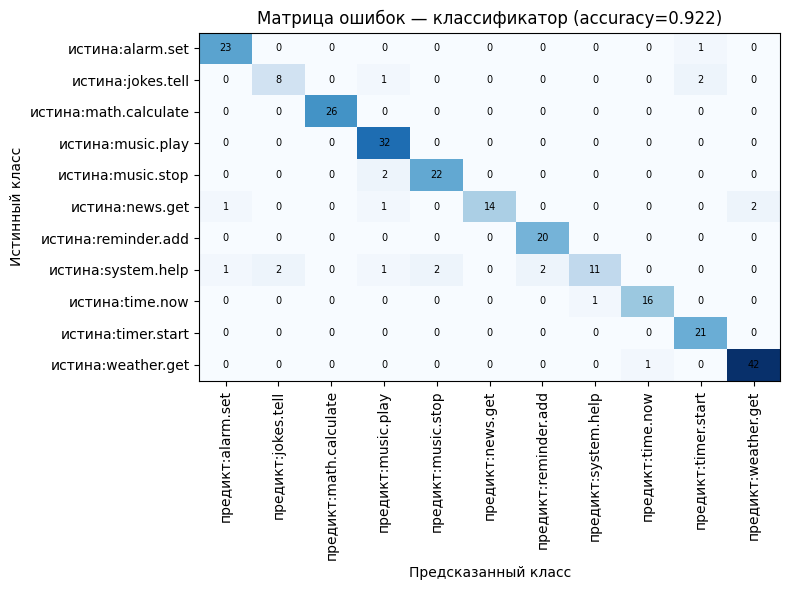

/tmp/ipython-input-1528698541.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df_metrics["skill"], rotation=70)


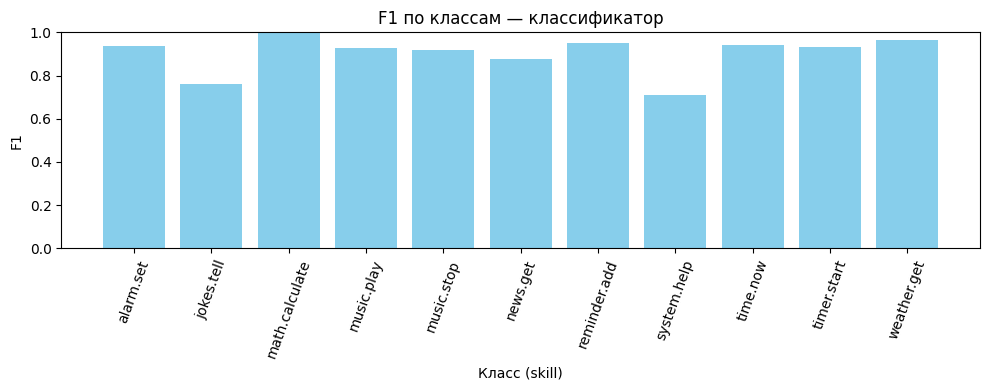

,skill,precision,recall,f1,support
0,alarm.set,0.920000,0.958333,0.938776,24
1,jokes.tell,0.800000,0.727273,0.761905,11
2,math.calculate,1.000000,1.000000,1.000000,26
3,music.play,0.864865,1.000000,0.927536,32
4,music.stop,0.916667,0.916667,0.916667,24
5,news.get,1.000000,0.777778,0.875000,18
6,reminder.add,0.909091,1.000000,0.952381,20
7,system.help,0.916667,0.578947,0.709677,19
8,time.now,0.941176,0.941176,0.941176,17
9,timer.start,0.875000,1.000000,0.933333,21


KeyError: 'skill'

In [13]:
#оценка точности
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_recall_fscore_support
from IPython.display import display

# классы
skills_set = set(r["skill"] for r in dev_rows)
if 'skills' in globals():
    skills_set |= set(skills)
labels = sorted(skills_set)

def per_class_df(y_true, y_pred, labels):
    p,r,f1,supp = precision_recall_fscore_support(y_true, y_pred, labels=labels, zero_division=0)
    return pd.DataFrame({"skill":labels, "precision":p, "recall":r, "f1":f1, "support":supp})

def plot_confusion(cm_df, title_ru):
    fig = plt.figure(figsize=(8,6))
    ax = plt.gca()
    ax.imshow(cm_df.values, aspect='auto', cmap='Blues')
    ax.set_xticks(np.arange(cm_df.shape[1])); ax.set_yticks(np.arange(cm_df.shape[0]))
    ax.set_xticklabels(cm_df.columns, rotation=90); ax.set_yticklabels(cm_df.index)
    ax.set_xlabel("Предсказанный класс"); ax.set_ylabel("Истинный класс")
    ax.set_title(title_ru)
    for i in range(cm_df.shape[0]):
        for j in range(cm_df.shape[1]):
            ax.text(j, i, str(cm_df.iat[i,j]), ha='center', va='center', fontsize=7)
    fig.tight_layout()
    plt.show()

def plot_bar_f1(df_metrics, title_ru):
    fig = plt.figure(figsize=(10,4))
    ax = plt.gca()
    ax.bar(df_metrics["skill"], df_metrics["f1"], color="skyblue")
    ax.set_ylim(0,1)
    ax.set_xlabel("Класс (skill)"); ax.set_ylabel("F1")
    ax.set_title(title_ru)
    ax.set_xticklabels(df_metrics["skill"], rotation=70)
    fig.tight_layout()
    plt.show()

# Классификатор
y_true_c, y_pred_c = [], []
for r in dev_rows:
    masked, _ = mask_entities(r["text"])
    proba, pred_label, _ = clf_prob_ours(masked)
    y_true_c.append(r["skill"])
    y_pred_c.append(pred_label)

acc_c = accuracy_score(y_true_c, y_pred_c)
cm_c = confusion_matrix(y_true_c, y_pred_c, labels=labels)
df_cm_c = pd.DataFrame(cm_c, index=[f"истина:{c}" for c in labels], columns=[f"предикт:{c}" for c in labels])
df_metrics_c = per_class_df(y_true_c, y_pred_c, labels)

print(f"Точность (классификатор): {acc_c:.3f}")
plot_confusion(df_cm_c, f"Матрица ошибок — классификатор (accuracy={acc_c:.3f})")
plot_bar_f1(df_metrics_c, "F1 по классам — классификатор")
display(df_metrics_c)

# RankSkill
y_true_r, y_pred_r = [], []
for r in dev_rows:
    got = rank_skill(r["text"])
    y_true_r.append(r["skill"])
    y_pred_r.append(got["skill"])

acc_r = accuracy_score(y_true_r, y_pred_r)
cm_r = confusion_matrix(y_true_r, y_pred_r, labels=labels)
df_cm_r = pd.DataFrame(cm_r, index=[f"истина:{c}" for c in labels], columns=[f"предикт:{c}" for c in labels])
df_metrics_r = per_class_df(y_true_r, y_pred_r, labels)

print(f"Точность (rank_skill): {acc_r:.3f}")
plot_confusion(df_cm_r, f"Матрица ошибок — rank_skill (accuracy={acc_r:.3f})")
plot_bar_f1(df_metrics_r, "F1 по классам — rank_skill")
display(df_metrics_r)

In [14]:
from collections import Counter

def evaluate_on_dev():
    hits_top1 = 0
    hits_top3 = 0
    abstain_count = 0

    y_true = []
    y_pred = []

    for r in dev_rows:
        gold = r["skill"]
        out = rank_skill(r["text"])

        if out["abstain"]:
            abstain_count += 1

        pred = out["intent"]
        y_true.append(gold)
        y_pred.append(pred)

        if pred == gold:
            hits_top1 += 1

        top3_skills = [c["skill"] for c in out["candidates"][:3]]
        if gold in top3_skills:
            hits_top3 += 1

    n = len(dev_rows)
    acc = hits_top1 / n
    acc3 = hits_top3 / n
    macro = f1_score(y_true, y_pred, average="macro", zero_division=0)

    print(f"Dev size: {n}")
    print(f"Top-1 accuracy: {acc:.3f}")
    print(f"Top-3 hit rate: {acc3:.3f}")
    print(f"Macro F1 (with abstain label): {macro:.3f}")
    print(f"Abstain rate: {abstain_count / n:.3f}")

evaluate_on_dev()


Dev size: 255
Top-1 accuracy: 0.776
Top-3 hit rate: 0.925
Macro F1 (with abstain label): 0.782
Abstain rate: 0.275


# Тест

In [15]:
def ask(q: str):
    res = rank_skill(q)
    print("=" * 60)
    print("Query: ", res["query"])
    print("Masked:", res["masked"])
    print("Intent:", res["intent"], f"(conf={res['confidence']})")
    print("Abstain:", res["abstain"])
    print("Slots: ", res["slots"])
    print("Top candidates:")
    for c in res["candidates"]:
        print(f"  - {c['skill']:<20} score={c['score']:.3f}")
    print("Matched example:", res["matched_example"])
    print("=" * 60)
    return res

while True:
    q = input(">>> ").strip()
    if q.lower() in {"q", "quit", "exit"}:
        break
    if not q:
        continue
    ask(q)


>>> погода
Query:  погода
Masked: погода
Intent: system.help (conf=0.307)
Abstain: True
Slots:  {}
Top candidates:
  - weather.get          score=0.307
  - news.get             score=0.283
  - news.get             score=0.265
  - news.get             score=0.247
  - news.get             score=0.242
Matched example: Погода
>>> таймер
Query:  таймер
Masked: таймер
Intent: system.help (conf=0.269)
Abstain: True
Slots:  {}
Top candidates:
  - timer.start          score=0.269
  - timer.start          score=0.265
  - timer.start          score=0.235
  - timer.start          score=0.223
  - timer.start          score=0.212
Matched example: Таймер
>>> будильник
Query:  будильник
Masked: будильник
Intent: system.help (conf=0.361)
Abstain: True
Slots:  {}
Top candidates:
  - alarm.set            score=0.361
  - alarm.set            score=0.332
  - alarm.set            score=0.328
  - alarm.set            score=0.325
  - alarm.set            score=0.318
Matched example: Будильник
>>> поставь буди